## Setup

* Conda enviroment -> sentinelhub and eolearn package via pip, check dependencies!
* Create SentinelHub account. Set ID in terminal: sentinelhub.config --instance_id YOUR_INSTANCE_ID

In [1]:
# Basics
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from shapely.geometry import Polygon
import pandas as pd
import os

# Coordinates
import geopandas as gpd

#  Satellite related
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam
from eolearn.core import EOTask, EOPatch, LinearWorkflow, EOWorkflow, FeatureType, Dependency, OverwritePermission, LoadFromDisk, SaveToDisk
from eolearn.io import S2L1CWCSInput
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask
from eolearn.features import LinearInterpolation, SimpleFilterTask

## Creating Region of Interest

* Obtain a file which describes your ROI
  * Little description about the GeoJSON format: [Link](http://geojson.org/)
  * Generate GeoJSON file from manually marked area: [Link](http://geojson.io)
  * Download free stuff: [Link](http://www.naturalearthdata.com/downloads/10m-cultural-vectors/)
* Convert it to selected CRS: taken to be the CRS of central UTM tile (UTM_33N)

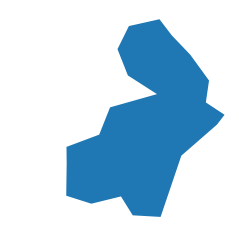

Dimension of the area is 104335 x 130284 m2


In [2]:
# Load geojson file
ROI = gpd.read_file('roi.geojson')

# Convert CRS to UTM_33N
ROI_crs = CRS.UTM_33N
ROI = ROI.to_crs(crs={'init':CRS.ogc_string(ROI_crs)})

# Get the ROI's shape in polygon format
ROI_shape = ROI.geometry.values.tolist()[-1]

# Plot ROI
ROI.plot()
plt.axis('off');
plt.show();

# Print size 
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(ROI_shape.bounds[2]-ROI_shape.bounds[0],ROI_shape.bounds[3]-ROI_shape.bounds[1]))

## Spliting Region of Interest

Aiming to make 5x5 km patches.

In [3]:
# Change these if ROI size changes (last param)

# Grid resolution from tartget patch size
grid_size_x = 21
grid_size_y = 26

# Create the splitter to obtain a list of bboxes
# Change number of patches if ROI size changes (last param)
bbox_splitter = BBoxSplitter([ROI_shape], ROI_crs, (grid_size_x, grid_size_y))

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Prepare info of all EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_splitter.bbox_list]
idxs_x = [info['index_x'] for info in bbox_splitter.info_list]
idxs_y = [info['index_y'] for info in bbox_splitter.info_list]
df = pd.DataFrame({'index_x':idxs_x, 'index_y':idxs_y})
gdf = gpd.GeoDataFrame(df, crs={'init':CRS.ogc_string(bbox_splitter.bbox_list[0].crs)}, geometry=geometry)

In [4]:
poly = gdf['geometry'][0]
x1,y1,x2,y2 = poly.bounds
aspect_ratio = (y1-y2)/(x1-x2)

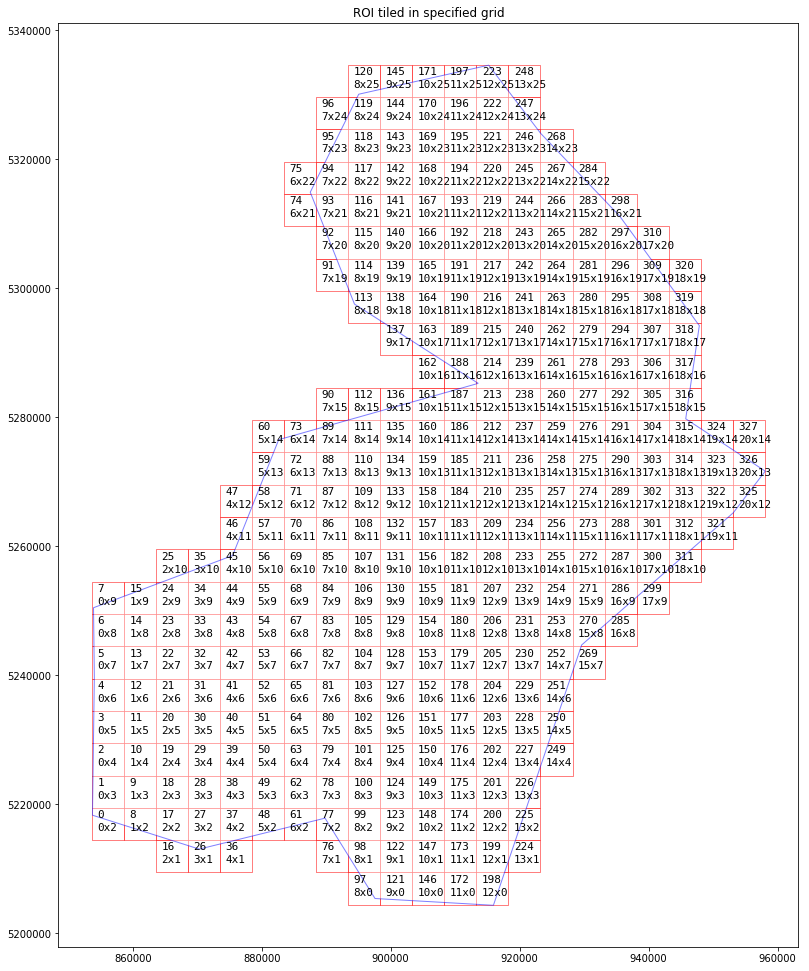

In [5]:
# Show tile structure
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 11}
# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu-xl)/3, (yu-yl)/5
# figure
fig, ax = plt.subplots(figsize=(25,17))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
ROI.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('ROI tiled in specified grid');
# add annotiation text
for idx in gdf.index:
    eop_name = '{0}x{1}'.format(gdf.index_x[idx], gdf.index_y[idx])
    centroid, = list(gdf.geometry[idx].centroid.coords)
    ax.text(centroid[0]-xoff, centroid[1]+yoff, '{}'.format(idx), fontdict=fontdict)
    ax.text(centroid[0]-xoff, centroid[1]-yoff, eop_name, fontdict=fontdict)

In [6]:
# Select patch ID for download
ID = 127
patchIDs = []
patchIDs.append(ID)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(1, 1))).ravel()

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list[patchIDs]]
idxs_x = [info['index_x'] for info in info_list[patchIDs]]
idxs_y = [info['index_y'] for info in info_list[patchIDs]]
df = pd.DataFrame({'index_x': idxs_x, 'index_y': idxs_y})
gdf = gpd.GeoDataFrame(df, crs={'init': CRS.ogc_string(ROI_crs)}, geometry=geometry)

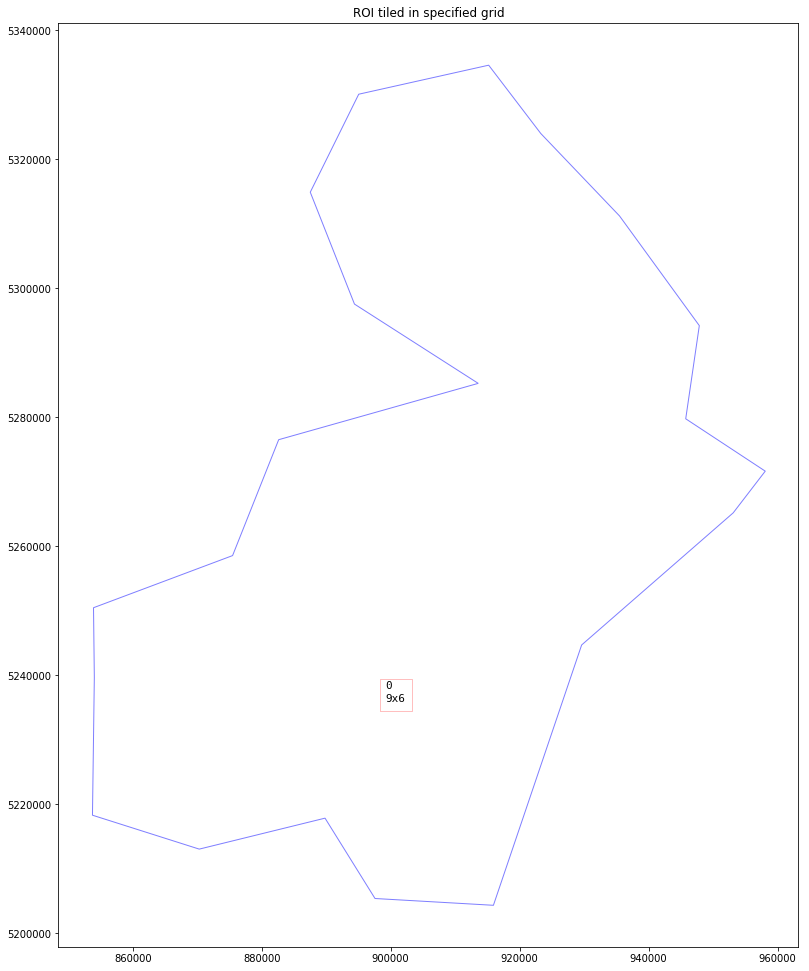

In [7]:
# Show dowloaded tile(s)

# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu-xl)/3, (yu-yl)/5
# figure
fig, ax = plt.subplots(figsize=(25,17))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
ROI.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('ROI tiled in specified grid');
# add annotiation text
for idx in gdf.index:
    eop_name = '{0}x{1}'.format(gdf.index_x[idx], gdf.index_y[idx])
    centroid, = list(gdf.geometry[idx].centroid.coords)
    ax.text(centroid[0]-xoff, centroid[1]+yoff, '{}'.format(idx), fontdict=fontdict)
    ax.text(centroid[0]-xoff, centroid[1]-yoff, eop_name, fontdict=fontdict)

## Fill EOPatches with data

Now it's time to create EOPatches and fill them with Sentinel-2 data using Sentinel Hub services. We will add the following data to each EOPatch. L1C has global covarage.

Layers has to be created in SentinelHub Dashboard: BANDS-S2-L1C

* L1C custom list of bands: (https://en.wikipedia.org/wiki/Sentinel-2)
  * Band 1 – Coastal aerosol
  * Band 2 – Blue
  * Band 3 – Green
  * Band 4 – Red
  * Band 5 – Vegetation red edge	(704.1/703.8 nm)
  * Band 6 – Vegetation red edge	(740.5, 739.1 nm)
  * Band 7 – Vegetation red edge	(782.8, 779.7 nm)
  * Band 8 – NIR
  * Band 8A – Narrow NIR
  * Band 9 – Water vapour
  * Band 10 – SWIR – Cirrus
  * Band 11 – SWIR1
  * Band 12 – SWIR2
* ~~SentinelHub's cloud probability map and cloud mask~~
* Calculated NDVI, NDWI, euclidean NORM information
* ~~A mask of validity, based on acquired data from sentinel and cloud coverage~~
    ~~Valid pixel is if:~~
    ~~IS_DATA == True~~
    ~~CLOUD_MASK == 0 (1 indicates that pixel was identified to be covered with cloud)~~

In [8]:
class NormalizedDifferenceIndex(EOTask):   
    """
    The tasks calculates user defined Normalised Difference Index (NDI) between two bands A and B as:
    NDI = (A-B)/(A+B).
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name=feature_name
        self.band_a_fetaure_name=band_a.split('/')[0]
        self.band_b_fetaure_name=band_b.split('/')[0]
        self.band_a_fetaure_idx=int(band_a.split('/')[-1])
        self.band_b_fetaure_idx=int(band_b.split('/')[-1])
        
    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]
        
        ndi = (band_a-band_b)/(band_a+band_b)
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, ndi[...,np.newaxis])
        
        return eopatch

    
class EuclideanNorm(EOTask):   
    """
    The tasks calculates Euclidian Norm of all bands within an array:
    
    norm = sqrt(sum_i Bi**2),
    
    where Bi are the individual bands within user-specified feature array.
    """
    def __init__(self, feature_name, in_feature_name):
        self.feature_name=feature_name
        self.in_feature_name=in_feature_name
    
    def execute(self, eopatch):
        arr = eopatch.data[self.in_feature_name]
        norm = np.sqrt(np.sum(arr**2, axis=-1))
        
        eopatch.add_feature(FeatureType.DATA, self.feature_name, norm[...,np.newaxis])
        return eopatch

In [9]:
# save to output?
# recommended if you have memory issues
save_choice = True  

# TASK FOR BAND DATA
# add a request for B01-B12 
# from default layer 'ALL_BANDS' at 10m resolution
custom_script = 'return [B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B10, B11, B12];'
add_data = S2L1CWCSInput(
    layer='BANDS-S2-L1C', 
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 12 specific bands
    resx='10m', # resolution x
    resy='10m', # resolution y
    maxcc=0.8, # maximum allowed cloud cover of original ESA tiles
)

# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NORM: sqrt(B02^2 + B03^2 + B04^2 + B08^2 + B11^2 + B12^2)
ndvi = NormalizedDifferenceIndex('NDVI', 'BANDS/7', 'BANDS/3')
ndwi = NormalizedDifferenceIndex('NDWI', 'BANDS/2', 'BANDS/7')
norm = EuclideanNorm('NORM','BANDS')

# TASK FOR SAVING TO OUTPUT (if needed)
path_out = './eopatches/'
if not os.path.isdir(path_out) and save_choice:
    os.makedirs(path_out)
save = SaveToDisk(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

## Define the workflow

* Create EOPatches with band data
* ~~Add cloud info~~
* Calculate and add NDVI, NDWI, NORM
* ~~Add mask of valid pixels~~
* ~~Add scalar feature representing the cound of valid pixels~~
* Save eopatches

In [10]:
if save_choice:
    save_task = [save]
else:
    save_task = []

# Define the workflow
workflow = LinearWorkflow(
    add_data,
    # add_clm,
    ndvi,
    ndwi,
    norm,
    # add_sh_valmask,
    # count_val_sh,
    *save_task
)

In [11]:
%%time

# Execute the workflow
eopatches = [] # container for the full eopatches
time_interval = ['2018-01-01','2018-12-31'] # time interval for the SH request

# Show progress bar 
for idx, bbox in enumerate(bbox_list[patchIDs]):
    # define additional parameters of the workflow
    extra_param = {add_data:{'bbox':bbox, 'time_interval':time_interval}}
    if save_choice:
        extra_param[save] = {'eopatch_folder': 'eopatch_{}'.format(idx)}
    
    result = workflow.execute(extra_param)    
    if save_choice:
        del result
    else:
        eopatches.append(result[list(result.keys())[-1]])

Wall time: 31.7 s


## Visualize the patches

All patches come from a small region. They probably has the same capture date. No interpolation needed to check them.

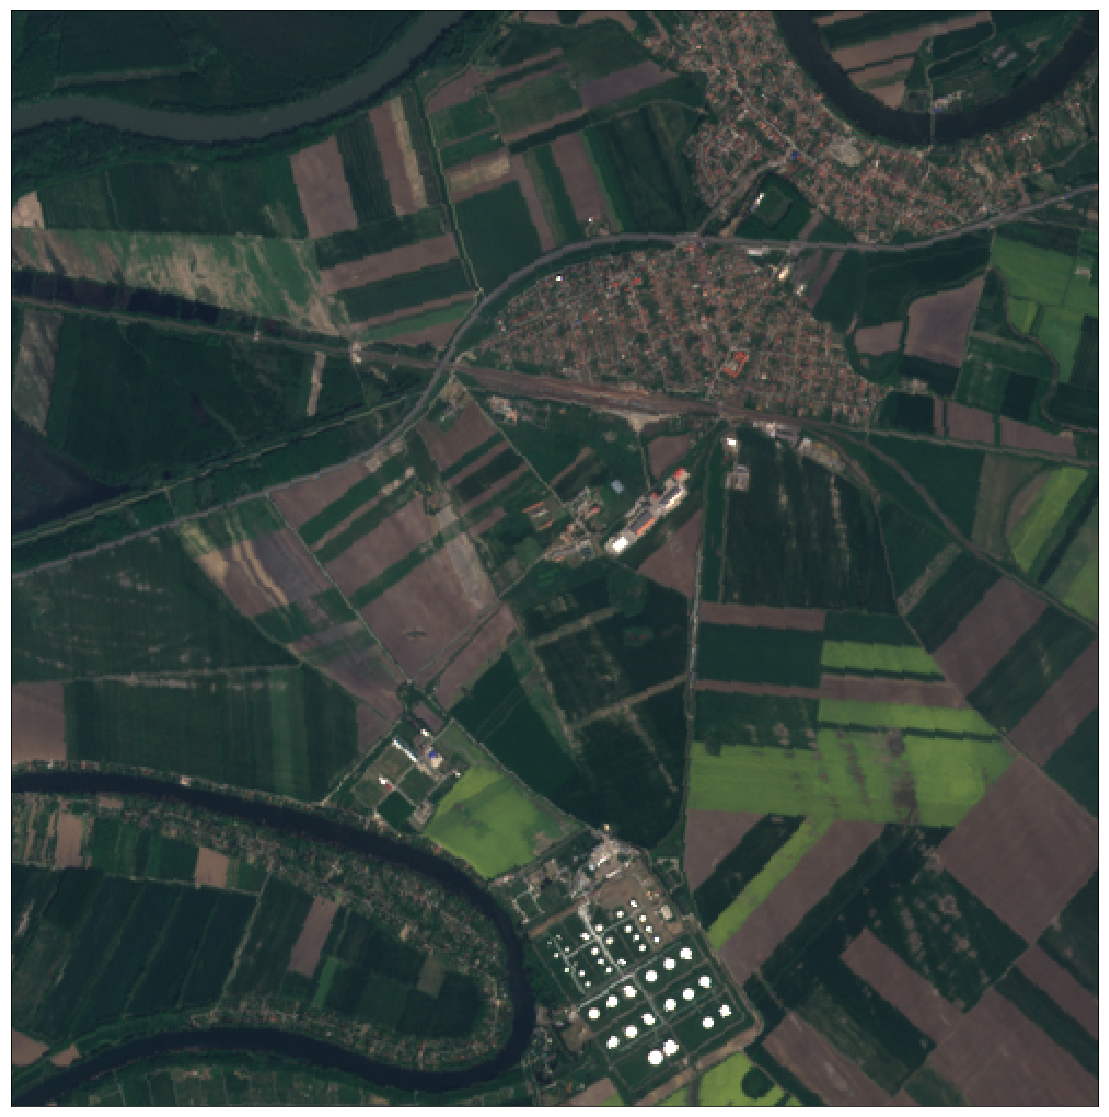

In [14]:
## Draw the RGB image
path_out = './eopatches/'
time_index = 11
eopatch = EOPatch.load('{}/eopatch_{}'.format(path_out, 0))

fig = plt.figure(figsize=(20,20*aspect_ratio))
plt.imshow(np.clip(eopatch.data['BANDS'][time_index][...,[3,2,1]]*3.5,0,1))
plt.xticks([])
plt.yticks([])
fig.subplots_adjust(wspace=0, hspace=0)